# Diseases MLR and corr with phenotypes 

Last modification: 09/08/2022

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime

DATE = datetime.now().strftime("%Y-%m-%d")

In [388]:
file_info_name='pheno_info_main.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'+str(file_info_name)
display_info=False
ventile='ventile5'
diseases_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/diseases_cov/2022_07_08_'+str(ventile)+'_diseases_cov.csv'
pheno_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/participant_phenotype/2022_08_03_'+str(ventile)+'_corrected_z.csv'
output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

In [389]:
if file_info_name=='pheno_info_sup.csv':
    list_phenotypes=['AVScore_all', 'tau1_all', 'tau1_artery', 'tau1_vein', 'tau2_all', 'tau2_artery', 'tau2_vein', 
                     'tau4_all', 'tau4_artery', 'tau4_vein', 'D_std', 'D_A_std', 'D_V_std', 'D_median_CVMe', 'D_CVMe', 
                     'D_CVMe_A', 'D_CVMe_V', 'N_median_main_arteries', 'N_median_main_veins', 'arcLength_artery', 'arcLength_vein', 
                     'bifurcations', 'VD_orig_all', 'VD_orig_artery', 'VD_orig_vein', 'ratio_VD', 'slope', 'slope_artery', 'slope_vein', 
                     'mean_angle_taa', 'mean_angle_tva', 'medianCenter1_artery', 'medianCenter1_vein', 'medianCenter2_artery', 'medianCenter2_vein', 
                     'eq_CRAE', 'eq_CRVE', 'median_CRAE', 'median_CRVE', 'ratio_CRAE_CRVE', 'ratio_median_CRAE_CRVE', 'medianDiameter_all',
                     'medianDiameter_artery','medianDiameter_vein', 'ratio_AV_medianDiameter']
    
if file_info_name=='pheno_info_main.csv':
    list_phenotypes=["tau1_artery", "tau1_vein", "D_A_std", "D_V_std", "bifurcations", "VD_orig_artery", "VD_orig_vein", 
                     "ratio_VD", "mean_angle_taa" , "mean_angle_tva", "eq_CRAE", "eq_CRVE", "ratio_CRAE_CRVE",
                     "medianDiameter_artery", "medianDiameter_vein", "ratio_AV_medianDiameter"]

### 1 - Read diseases:

In [390]:
df_diseases=pd.read_csv(diseases_file, sep=',')

##### Number of cases and controls per disease

In [391]:
def N_of_nans_and_nonans(df_,disease):
    print('- ', disease,': ', 
          len(df_[disease]) - df_[disease].isna().sum(),
          (df_[disease].isna().sum()/len(df_[disease])).round(4))#, '\n')
    
if display_info==True:
    print('Number of nans and ratio nans/no_nans:')
    for disease_name in diseases_list:
        N_of_nans_and_nonans(df_diseases,disease_name)

#### Read diseases info

In [392]:
inf = pd.read_csv(pheno_info_file)
### NOTE: Delete vascular_heart_problems since I am not sure of what the different values are:
#inf.drop(inf[(inf['name']=='vascular_heart_problems_00')].index, inplace=True)
##### Delete alcohol_intake_frequency_00
#inf.drop(inf[(inf['name']=='alcohol_intake_frequency_00')].index, inplace=True)

# Lists of phenotypes
list_diseases = inf['name'].values

list_diseases_bin = inf.loc[inf['dtype']=='bin', 'name'].values # binary phenotypes
list_diseases_con = inf.loc[inf['dtype']=='con', 'name'].values # continuous phenotypes
list_diseases_cat = inf.loc[inf['dtype']=='cat', 'name'].values # categorical phenotypes

### 2 - Phenotypes:

In [393]:
### Read phenos
df_pheno=pd.read_csv(pheno_file, sep=',')

In [394]:
### Just to double-check: Replace -999 by np.nan
df_pheno = df_pheno.replace(-999.00, np.nan)
#print(df_pheno.isna().sum())

In [395]:
## Rename to eid to make the merge
df_pheno.rename(columns={'Unnamed: 0': 'eid'}, inplace=True)

### 3 - Merge diseases and phenotpyes

In [396]:
### Delete nans
#df_phenotypes=df_pheno.dropna()
#print('Delete subjects with nans, len before and after :',len(df_pheno), len(df_phenotypes))

In [397]:
df_pheno_dise=df_pheno.merge(df_diseases, how='left', on='eid')
print('Len BEFORE merge: pheno size , diseases size: ', len(df_pheno), len(df_diseases))
print('Len AFTER merge: ', len(df_pheno_dise))
#print(df_pheno_dise.columns)

Len BEFORE merge: pheno size , diseases size:  77115 81859
Len AFTER merge:  77115


## Filtrate only by the phenotypes and diseases of interest

In [398]:
list_phenos_diseases = list_phenotypes+list(list_diseases)

In [399]:
df_pheno_dise=df_pheno_dise[list_phenos_diseases]
df_pheno_dise

,tau1_artery,tau1_vein,D_A_std,D_V_std,bifurcations,VD_orig_artery,VD_orig_vein,ratio_VD,mean_angle_taa,mean_angle_tva,...,alcohol_intake_frequency_00,pulse_wave_arterial_stiffness_index_00,BMI,Pack_year_smok,HDL_cholesterol,LDL_direct,Triglycerides,HbA1c,skin_colour,hair_colour
0,-0.014589,1.169884,0.643480,0.912407,-0.882606,-0.034287,-0.648550,0.659063,0.026629,0.433526,...,4.0,8.43590,18.9947,NaN,1.204,1.286,0.596,19.1,2.0,5.0
1,0.436273,1.564541,1.048687,-0.472586,-0.891035,-1.073063,-1.070843,-0.311907,NaN,NaN,...,1.0,9.98942,28.9238,NaN,1.106,4.307,1.521,36.3,3.0,4.0
2,-0.001302,-0.051543,-0.628146,-0.789148,0.728931,0.648034,0.563089,0.229803,0.499851,-1.124371,...,2.0,10.39770,26.4266,NaN,1.108,3.627,1.662,36.3,3.0,5.0
3,-0.066754,2.053665,-0.220528,-0.301639,-0.635511,-0.734972,-1.136659,0.288663,1.678741,NaN,...,4.0,7.96380,26.5690,NaN,1.306,4.982,1.707,39.3,3.0,3.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,8.83495,35.7445,NaN,0.997,2.737,2.918,65.1,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,6.12500,24.8557,NaN,1.747,2.819,1.465,40.2,2.0,3.0
77111,2.649257,-0.510072,-0.471703,-0.059277,-0.481274,0.284583,-1.197317,1.710748,-0.878541,-0.000944,...,2.0,NaN,28.2372,NaN,NaN,3.332,2.136,30.8,2.0,4.0
77112,-0.244132,0.055489,-0.277703,-0.414637,2.199730,2.037428,2.141887,0.329875,-0.183317,0.233806,...,1.0,7.02643,25.9431,NaN,1.862,3.673,0.859,35.2,3.0,5.0
77113,1.567324,0.125204,0.743502,0.066245,0.029521,0.335816,-0.201911,0.572771,0.741470,0.968176,...,2.0,9.89418,32.6575,NaN,0.873,3.573,1.088,46.7,3.0,4.0


## 4 - Correlation

In [400]:
import seaborn as sns

def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.pyplot.gca()
    ax.annotate(label, xy=(0.2, 0.95), size=20, xycoords=ax.transAxes)

In [401]:
matrix_total = df_pheno_dise.corr().round(1)
plt.figure(figsize=(10, 10), 
           dpi = 900) 
sns.heatmap(matrix_total, annot=True, vmax=1, vmin=-1, center=0, annot_kws={'size': 3}, cmap='vlag')

<AxesSubplot:>

### 4 - MLR

In [402]:
### Double check the numbers:
#print(df_pheno_dise_cov['age_cataract_00'].value_counts(), df_pheno_dise_cov['age_macular_deg_diag'].value_counts())

In [403]:
for col in df_pheno_dise.columns:
    # Make variables that start with "age_" binary (0 in NaN, 1 if not NaN)
    if col.startswith('age_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0

    elif col.startswith('date_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0

    # Same for variables starting with "eye_" 
    elif col.startswith('eye_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0
        
df_pheno_dise.head(15)

,tau1_artery,tau1_vein,D_A_std,D_V_std,bifurcations,VD_orig_artery,VD_orig_vein,ratio_VD,mean_angle_taa,mean_angle_tva,...,alcohol_intake_frequency_00,pulse_wave_arterial_stiffness_index_00,BMI,Pack_year_smok,HDL_cholesterol,LDL_direct,Triglycerides,HbA1c,skin_colour,hair_colour
0,-0.014589,1.169884,0.643480,0.912407,-0.882606,-0.034287,-0.648550,0.659063,0.026629,0.433526,...,4.0,8.43590,18.9947,NaN,1.204,1.286,0.596,19.1,2.0,5.0
1,0.436273,1.564541,1.048687,-0.472586,-0.891035,-1.073063,-1.070843,-0.311907,NaN,NaN,...,1.0,9.98942,28.9238,NaN,1.106,4.307,1.521,36.3,3.0,4.0
2,-0.001302,-0.051543,-0.628146,-0.789148,0.728931,0.648034,0.563089,0.229803,0.499851,-1.124371,...,2.0,10.39770,26.4266,NaN,1.108,3.627,1.662,36.3,3.0,5.0
3,-0.066754,2.053665,-0.220528,-0.301639,-0.635511,-0.734972,-1.136659,0.288663,1.678741,NaN,...,4.0,7.96380,26.5690,NaN,1.306,4.982,1.707,39.3,3.0,3.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,8.83495,35.7445,NaN,0.997,2.737,2.918,65.1,2.0,4.0
5,-0.790813,-0.620703,-1.065825,-0.064842,0.788635,0.646806,1.076468,-0.225484,0.323412,1.654945,...,1.0,10.22470,27.8046,NaN,1.315,3.312,1.256,35.3,2.0,4.0
6,1.540807,-1.119643,0.348119,-1.192775,-1.352122,-1.228878,-1.117206,-0.568578,NaN,NaN,...,2.0,12.46150,24.9962,NaN,1.594,4.005,1.637,35.4,2.0,4.0
7,-0.928325,-1.015320,-1.742888,-1.990024,0.724252,0.075434,0.648738,-0.590281,-0.109028,-1.917558,...,1.0,7.98995,21.6764,5.25,1.871,4.382,1.090,34.4,1.0,1.0
8,1.139739,0.196355,-0.112167,-0.594222,-0.452441,-0.547786,-0.891607,0.164281,-0.921724,0.461728,...,2.0,11.11840,31.0213,NaN,1.471,3.121,2.063,32.4,2.0,3.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,8.57895,21.6794,NaN,1.814,3.891,0.922,38.1,1.0,2.0


#### Standardise continuous diseases

In [404]:
# Standardise continuous phenotypes

for var in list_diseases_con:
    mu = np.mean(df_pheno_dise[var])
    sig = np.std(df_pheno_dise[var])
    df_pheno_dise[var] = (df_pheno_dise[var]-mu)/sig


##### Check the type of variables and convert objects to numeric:

In [405]:
print(df_pheno_dise.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77115 entries, 0 to 77114
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tau1_artery                             67554 non-null  float64
 1   tau1_vein                               67555 non-null  float64
 2   D_A_std                                 67554 non-null  float64
 3   D_V_std                                 67554 non-null  float64
 4   bifurcations                            67554 non-null  float64
 5   VD_orig_artery                          67555 non-null  float64
 6   VD_orig_vein                            67555 non-null  float64
 7   ratio_VD                                67555 non-null  float64
 8   mean_angle_taa                          55308 non-null  float64
 9   mean_angle_tva                          58074 non-null  float64
 10  eq_CRAE                                 56157 non-null  fl

In [407]:
### convert to type numeric the columns that are not
if file_info_name=='pheno_info_sup.csv':
    df_pheno_dise['date_reported_atherosclerosis'] = pd.to_numeric(df_pheno_dise['date_reported_atherosclerosis'])
    df_pheno_dise['date_disorders_arteries_arterioles'] = pd.to_numeric(df_pheno_dise['date_disorders_arteries_arterioles'])
    df_pheno_dise['date_AD'] = pd.to_numeric(df_pheno_dise['date_AD']) 
    df_pheno_dise['date_death'] = pd.to_numeric(df_pheno_dise['date_death']) 
    #print(df_pheno_dise.info())

###  Linear/logistic regression

In [408]:
#list_phenos_diseases, list_phenotypes, list(list_diseases)

betas = pd.DataFrame(columns=list_diseases, index=list_phenotypes)
log10p = pd.DataFrame(columns=list_diseases, index=list_phenotypes)

for out in list_diseases:
    for reg in list_phenotypes:
        #print(out, reg)
        ### checking the min and max values
        #print(df_pheno_dise[out].min(), df_pheno_dise[out].max())
        
        # OLS regression for categorical/ordinal and continuous outcomes
        if (inf.loc[inf['name']==out, 'dtype'].values[0]=='cat') | (inf.loc[inf['name']==out, 'dtype'].values[0]=='con'):
            model = ols(formula=out+'~'+reg, data=df_pheno_dise)
        # Logistic regression for binary outcomes
        elif inf.loc[inf['name']==out, 'dtype'].values[0]=='bin':
            model = logit(formula=out+'~'+reg, data=df_pheno_dise)
            # results = model.fit(method='bfgs')
        results = model.fit()
        betas.loc[reg, out] = results.params[reg]
        log10p.loc[reg, out] = -np.log10(results.pvalues[reg])


betas.to_csv(output_dir+'reg_betas_'+ventile+'.csv')
log10p.to_csv(output_dir+'reg_log10p_'+ventile+'.csv')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


In [409]:
# Regression heatmaps
## NB: infinite -log10(p) are arbitrarily replaced by a fixed value ('inf_val') for visualisation
#inf_val = 310

betas = betas.astype('float64') # in case betas was coded as object type

## This colours by -log10(p) and annotates betas
## NOT VERY READABLE: DELETE??
#fig = plt.figure(figsize=(20, 16))
#sns.heatmap(log10p.replace(np.inf, inf_val), annot=betas.round(2), cmap='Blues', vmin=0, cbar_kws={'label': '-log10(p)'})
#plt.close()

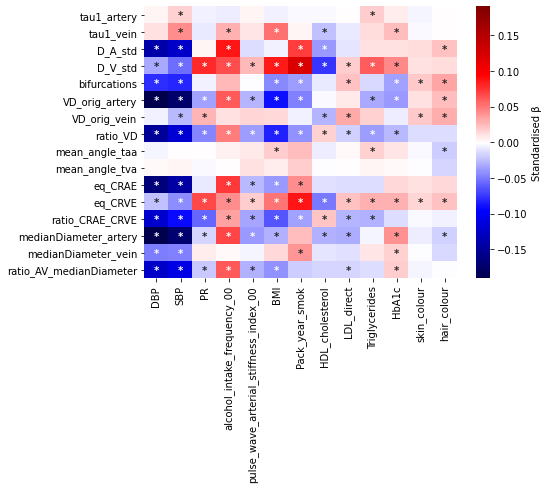

In [411]:
## This colours by beta and annotates Bonferroni-significant models with an asterisk
Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))


if file_info_name=='pheno_info_sup.csv':
    fig = plt.figure(figsize=(10, 10))
    imagen=sns.heatmap(betas, annot=(log10p>Bonf_thresh).replace({True:'*', False:''}), fmt="", annot_kws={'weight': 'bold'}, vmin=-abs(betas).max().max(), vmax=abs(betas).max().max(), cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'})
    plt.savefig(output_dir+ str(DATE)+'_MLR_'+ventile+'_sup.jpg', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)
else:
    fig = plt.figure(figsize=(7, 5))
    imagen=sns.heatmap(betas, annot=(log10p>Bonf_thresh).replace({True:'*', False:''}), fmt="", annot_kws={'weight': 'bold'}, vmin=-abs(betas).max().max(), vmax=abs(betas).max().max(), cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'})
    plt.savefig(output_dir+ str(DATE)+'_MLR_'+ventile+'.jpg', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)

#plt.close()

### cases and controls

In [ ]:
for i in list_diseases:
    print(i, df_pheno_dise[i].value_counts())
     